In [1]:
from time import time
import numpy as np
import logging
from pprint import pprint, pformat
import random
from collections import namedtuple
from copy import deepcopy
from multiprocessing import Pool
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

Nimply = namedtuple("Nimply", "row, num_objects")

/var/folders/2y/_ycqdwxs44z50d53gg4hp92w0000gn/T/ipykernel_13572/3707614075.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

In [3]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

In [4]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])

    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    candidate = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        candidate[ply] = nim_sum(tmp)
    return candidate


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis.items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis.keys())
    ply = random.choice(spicy_moves)
    return ply


def new_optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis.items() if ns == 1]
    if not spicy_moves:
        spicy_moves = list(analysis.keys())
    ply = random.choice(spicy_moves)
    return ply

In [5]:
def nim_game(num_rows: int, strategy1, strategy2) -> bool:
    """
    Simulate a game against the optimal strategie and returns True if your strategy 1 won
    """
    strategies = [strategy1, strategy2]
    nim = Nim(num_rows)
    player = 0
    while nim:
        move = strategies[player](nim)
        nim.nimming(move)
        player = 1 - player

    return player == 0


def simulate_games(num_games: int, num_rows: int, strategy1, strategy2) -> float:
    wins = 0
    for _ in range(num_games):
        if nim_game(num_rows, strategy1, strategy2):
            wins += 1
        if not nim_game(num_rows, strategy2, strategy1):
            wins += 1

    return wins / (2 * num_games)


def simulate_games_all(num_games: int, num_rows: int, strategy1) -> float:
    wins = 0
    for _ in range(num_games):
        for j in range(3):
            if nim_game(num_rows, strategy1, pure_random):
                wins += 1
            if not nim_game(num_rows, pure_random, strategy1):
                wins += 1
        if nim_game(num_rows, strategy1, optimal):
            wins += 1
        if not nim_game(num_rows, optimal, strategy1):
            wins += 1
        if nim_game(num_rows, strategy1, new_optimal):
            wins += 1
        if not nim_game(num_rows, new_optimal, strategy1):
            wins += 1

    return wins / (10 * num_games)

In [6]:

def policy(args):
    """
    This function defines returns a function handle that acts as a strategy defined from the args
    """
    def strategy(nim: Nim):
        """ Strategy that chooses the move that has the maximum value of arg correspondig to the nimsum """
        analysis = analize(nim)
        population = list()
        weights = list()
        for ply, ns in analysis.items():
            population.append(ply)
            weights.append(args[ns])

        # ply = random.choices(population=population, weights=weights, k=1)[0]
        return population[np.argmax(weights)]

    return strategy

def fitness1(n_rows: int, n_games: int, strategy2):
    '''Fitness evaluated against a specified strategy'''
    def fitness_func(args) -> float:
        strategy1 = policy(args)
        return simulate_games(n_games, n_rows, strategy1, strategy2)

    return fitness_func


def fitness2(n_rows: int, n_games: int):
    '''Fitness evaluated against all the strategies'''
    def fitness_func(args) -> float:
        strategy1 = policy(args)
        return simulate_games_all(n_games, n_rows, strategy1)

    return fitness_func

def fitness3(n_rows: int, n_games: int):
    '''Fitness evaluated between two indiidual of the population'''
    def fitness_func(arg1, arg2) -> float:
        strategy1 = policy(arg1)
        strategy2 = policy(arg2)

        return simulate_games(n_games, n_rows, strategy1, strategy2)

    return fitness_func

In [7]:
def ES_1_plus_lambda(_function, N_DIM, n_offspring=1_000):
    λ = 25
    σ = 0.1

    solution = np.random.normal(loc=0, scale=σ, size=N_DIM)
    history = list()
    best_so_far = np.copy(solution)
    best_eval = _function(solution)

    stats = [0, 0]
    for step in tqdm(range(n_offspring // λ)):
        samples = np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
        samples_evals = np.array([_function(samples[i]) for i in range(λ)])

        stats[0] += λ
        stats[1] += sum(samples_evals > best_eval)

        best_offspring = np.argmax(samples_evals)
        solution = samples[best_offspring]

        if best_eval < samples_evals[best_offspring]:
            best_eval = samples_evals[best_offspring]
            best_so_far = np.copy(solution) / np.max(solution)
            history.append((step, samples_evals[best_offspring]))

        if (step + 1) % 10 == 0:
            if stats[1] == 0 or stats[0] / stats[1] > 1 / 5:
                σ *= 1.1
            elif stats[0] / stats[1] < 1 / 5:
                σ *= 0.9
            stats = [0, 0]
    print(σ)
    return best_so_far, history

In [8]:
def ES_1_plus_lambda_against(_function, N_DIM, n_offspring=1_000):
    λ = 5
    σ = .75

    solution = np.random.normal(loc=0, scale=σ, size=N_DIM)
    history = list()
    best_so_far = np.copy(solution)


    for step in tqdm(range(n_offspring // λ)):
        samples = np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
        # make them play all with each other
        samples_evals = np.array([0 for i in range(λ)])
        for i in range(λ):
            for j in range(i, λ):
                if i == j:
                    samples_evals[i] += fitness1(n_games=2, n_rows=5, strategy2=pure_random)(samples[i])
                else:
                    result = _function(samples[i], samples[j])
                    samples_evals[i] += result
                    samples_evals[j] += (1 - result)

        samples_evals = samples_evals /(λ)

        best_offspring = np.argmax(samples_evals)
        solution = samples[best_offspring]

        if _function(best_so_far, solution) < 0.5:
            best_so_far = np.copy(solution) / np.max(solution)
            history.append((step, samples_evals[best_offspring]))

    return best_so_far, history

In [9]:
def ES_mu_plus_lambda(_function, N_DIM, n_offspring=1_000):
    μ = 10
    λ = 25
    σ = 0.01

    population = np.random.normal(loc=0, scale=σ, size=(µ, N_DIM + 1))

    population[:, -1] = σ

    best_fitness = None
    history = list()
    for step in tqdm(range(n_offspring // λ)):
        # offspring <- select λ random points from the population of μ
        offspring = population[np.random.randint(0, μ, size=(λ,))]
        # mutate all σ (last column) and replace negative values with a small number
        offspring[:, -1] = np.random.normal(loc=offspring[:, -1], scale=0.01)
        offspring[offspring[:, -1] < 1e-5, -1] = 1e-5
        # mutate all v (all columns but the last), using the σ in the last column
        offspring[:, 0:-1] = np.random.normal(
            loc=offspring[:, 0:-1], scale=offspring[:, -1].reshape(-1, 1)
        )

        fitness = np.array([_function(offspring[i, 0:-1]) for i in range(λ)])
        offspring = offspring[(-fitness).argsort()]
        # save best (just for the plot)
        if best_fitness is None or best_fitness < np.max(fitness):
            best_fitness = np.max(fitness)
            history.append((step, best_fitness))
        # select the μ with max fitness and discard fitness
        population = np.copy(offspring[:µ])
        population[:, 0:-1] = population[:, 0:-1] * (1 / np.max(population[0, 0:-1]))

    return population[0, 0:-1], history

In [10]:
N_ROWS = 5
N_GAMES = 5
ARG_DIM = 2 ** ((2 * N_ROWS - 1).bit_length())
best_solution1, history1 = ES_1_plus_lambda(
    fitness2(N_ROWS, N_GAMES), ARG_DIM, n_offspring=3_000
)

best_solution2, history2 = ES_mu_plus_lambda(
    fitness2(N_ROWS, N_GAMES), ARG_DIM, n_offspring=3_000
)

best_solution3, history3 = ES_1_plus_lambda_against(
    fitness3(N_ROWS, 1), ARG_DIM, n_offspring=3_000
)

100%|██████████| 120/120 [07:51<00:00,  3.93s/it]


0.3138428376721002


100%|██████████| 600/600 [01:17<00:00,  7.79it/s]


In [11]:
pprint(best_solution1)
pprint(best_solution2)
pprint(best_solution3)

array([-0.23778016,  0.22984342, -0.47931335, -0.2832044 , -0.03302355,
       -0.52057955, -0.23827783, -0.28139653,  0.10148469,  0.07550526,
        1.        , -0.05021842,  0.46610359,  0.12197271, -0.72106585,
        0.56729041])
array([ 0.41200414,  0.70432111,  0.04913144,  0.18547682, -0.16326169,
        0.23348727,  0.01183992,  0.69014098, -0.00195499, -0.15118913,
        1.        , -0.29790055,  0.06951548, -0.33038653,  0.53156053,
       -0.26913907])
array([ 0.0601764 ,  0.33241205, -0.0998508 ,  0.01180943, -0.54989958,
        0.39751649,  0.40870134,  0.06521053,  1.        ,  0.37308483,
       -0.37006606, -0.27010425, -0.35688819,  0.12945927, -0.06061815,
        0.17208197])


In [18]:
pprint(np.argsort(best_solution1))
pprint(np.argsort(best_solution2))
pprint(np.argsort(best_solution3))

print(fitness3(n_rows=N_ROWS, n_games=1)(best_solution2, best_solution1))
print(fitness3(n_rows=N_ROWS, n_games=1)(best_solution3, best_solution2))
print(fitness3(n_rows=N_ROWS, n_games=1)(best_solution3, best_solution1))

array([14,  5,  2,  3,  7,  6,  0, 11,  4,  9,  8, 13,  1, 12, 15, 10])
array([13, 11, 15,  4,  9,  8,  6,  2, 12,  3,  5,  0, 14,  7,  1, 10])
array([ 4, 10, 12, 11,  2, 14,  3,  0,  7, 13, 15,  1,  9,  5,  6,  8])
0.5
1.0
0.0


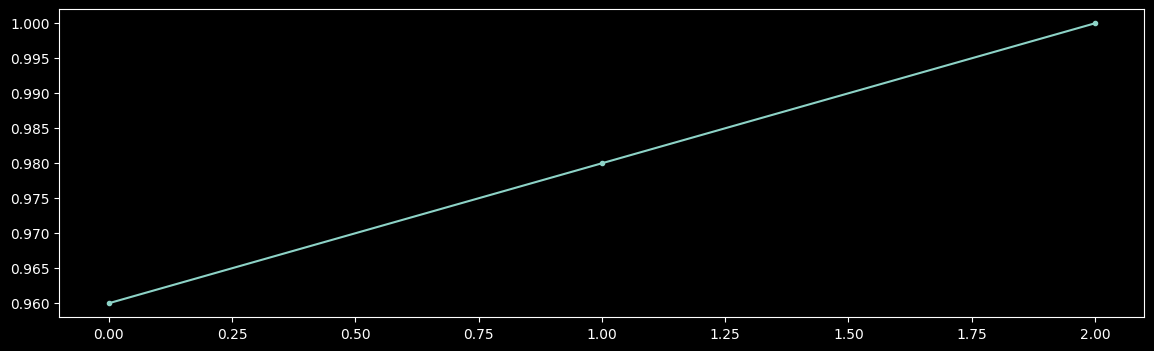

In [13]:
history = np.array(history1)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()

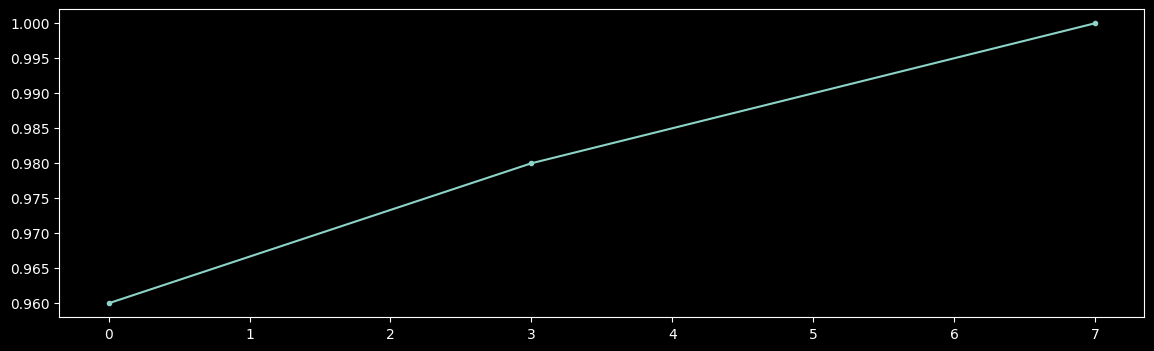

In [14]:
history = np.array(history2)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()

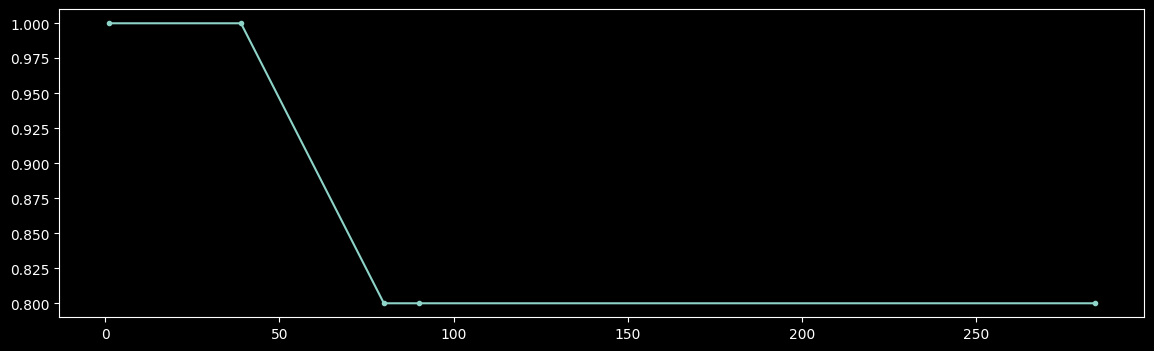

In [15]:
history = np.array(history3)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()

In [19]:
n_games = 50
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=pure_random)(best_solution1)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=gabriele)(best_solution1)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=optimal)(best_solution1)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=new_optimal)(best_solution1)*100,'%')

99.0 %
100.0 %
100.0 %
100.0 %


In [21]:
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=pure_random)(best_solution2)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=gabriele)(best_solution2)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=optimal)(best_solution2)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=new_optimal)(best_solution2)*100,'%')

97.0 %
100.0 %
100.0 %
100.0 %


In [22]:
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=pure_random)(best_solution3)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=gabriele)(best_solution3)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=optimal)(best_solution3)*100,'%')
print(fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=new_optimal)(best_solution3)*100,'%')

89.0 %
100.0 %
84.0 %
100.0 %
